**Packages installation**

In [171]:
#!pip install forex-python
#!pip install PyQt5 # visualisation problems

**Imports**

In [317]:
import numpy as np 
import pandas as pd 
from scipy import stats
from ydata_profiling import ProfileReport

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from forex_python.converter import CurrencyRates
import datetime as dt


from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix

%matplotlib inline

Merging all the CSV's into one dataset, and shuffling it with a specified seed for later reproductibility.

In [173]:
SEED = 42
np.random.seed(SEED)

In [174]:
dataset = pd.concat([pd.read_csv('Volkswagen_Golf.csv', na_values='Unknown'), pd.read_csv('BMW_Seria 3.csv', na_values='Unknown'), pd.read_csv('Opel_Corsa.csv', na_values='Unknown')])
dataset = dataset.sample(frac=1, random_state=SEED)
dataset.head()

brand    model                   generation    eng_cap  prod_year  \
1550  Volkswagen     Golf              VII (2012-2020)  1 984 cm3       2017   
1221  Volkswagen     Golf                 VIII (2020-)  1 968 cm3       2022   
1941  Volkswagen     Golf                 VIII (2020-)  1 968 cm3       2020   
573          BMW  Seria 3  E90/E91/E92/E93 (2005-2012)  2 996 cm3       2005   
173         Opel    Corsa                D (2006-2014)  1 229 cm3       2009   

       power fuel_type car_body     mileage   color condition  transmission  \
1550  310 KM   Benzyna  Kompakt   77 000 km   Biały   Używane  Automatyczna   
1221  150 KM    Diesel  Kompakt   32 000 km   Szary   Używane  Automatyczna   
1941  150 KM    Diesel  Kompakt   76 020 km  Czarny   Używane  Automatyczna   
573   258 KM   Benzyna    Sedan  288 858 km   Szary   Używane      Manualna   
173    80 KM   Benzyna  Kompakt  152 000 km  Czarny   Używane      Manualna   

       origin       price   source  
1550      NaN  114 000PLN  OTOMOTO  
1221   Polska   95 000PLN  OTOMOTO  
1941  Francja   86 900PLN  OTOMOTO  
573       NaN   32 500PLN  OTOMOTO  
173       NaN   18 500PLN  OTOMOTO

Checking how the data looks:

In [175]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6867 entries, 1550 to 860
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         6867 non-null   object
 1   model         6867 non-null   object
 2   generation    6805 non-null   object
 3   eng_cap       6782 non-null   object
 4   prod_year     6867 non-null   int64 
 5   power         6861 non-null   object
 6   fuel_type     6867 non-null   object
 7   car_body      6867 non-null   object
 8   mileage       6867 non-null   object
 9   color         6867 non-null   object
 10  condition     6867 non-null   object
 11  transmission  6865 non-null   object
 12  origin        4154 non-null   object
 13  price         6867 non-null   object
 14  source        6867 non-null   object
dtypes: int64(1), object(14)
memory usage: 858.4+ KB


As we can see, there are columns, e.g. mileage or price, which definitely should be an integer value, and instead, every column except prod_year is the type of an object. In order to execute exploratory data analysis, we have to prepare the data.

Let's preprocess the data in the following way:

brand - object

model - object

generation - object

eng_cap - int [cm^3]

prod_year - int

power - int [KM]

fuel_type - object

car_body - object

mileage - int [km]

color - object

condition - object

transmission - object

origin - object

price - int [zł]

source - object (we can drop it right away, because in all samples it has one value: **OTOMOTO**)



In [176]:
dataset['eng_cap'] = dataset['eng_cap'].apply(lambda x: float(x.replace('cm3', '').replace(' ', '')) if not pd.isnull(x) else x)
dataset['power'] = dataset['power'].apply(lambda x: float(x.replace('KM', '').replace(' ', '')) if not pd.isnull(x) else x)
dataset['mileage'] = dataset['mileage'].apply(lambda x: int(x.replace('km', '').replace(' ', '')) if not pd.isnull(x) else x)

With the price, situation is more complicated, because it can be given in different currencies. We have to convert them all to PLN

In [177]:
from forex_python.converter import CurrencyRates
import re
import functools

# caching, so that getting online info about certain currency happens only once for the same input 
@functools.cache
def get_currency(base_cur: str, dest_cur: str, date_obj: dt.datetime) -> float:
    c = CurrencyRates()
    try:
        rate = c.get_rate(base_cur=base_cur, dest_cur='PLN', date_obj=date_obj)
    except:
        print('LOOLOZ BLAD:', base_cur, dest_cur)
    if not isinstance(rate, float):
        raise ValueError(f'One of the following function arguments was incorrect: {base_cur, dest_cur, date_obj}')
    return rate

def currency_to_PLN(value: str) -> float:
    pattern = re.compile(r'([\d\s,]+)([^\d\s]+)')
    match = re.search(pattern, value)
    if match is None:
        raise ValueError(f'Unexpected price format: {value}')
    float_val = float(match.group(1).replace(' ', '').replace(',', '.'))
    base_curr = match.group(2)
    date = dt.datetime(2024, 5, 2, 12, 00) # set datetime for reproductability
    rate = get_currency(base_curr, 'PLN', date)
    return round(float_val * rate, 2)

dataset['price'] = dataset['price'].apply(lambda x: float(currency_to_PLN(x)) if not pd.isnull(x) else x)

In [178]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6867 entries, 1550 to 860
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         6867 non-null   object 
 1   model         6867 non-null   object 
 2   generation    6805 non-null   object 
 3   eng_cap       6782 non-null   float64
 4   prod_year     6867 non-null   int64  
 5   power         6861 non-null   float64
 6   fuel_type     6867 non-null   object 
 7   car_body      6867 non-null   object 
 8   mileage       6867 non-null   int64  
 9   color         6867 non-null   object 
 10  condition     6867 non-null   object 
 11  transmission  6865 non-null   object 
 12  origin        4154 non-null   object 
 13  price         6867 non-null   float64
 14  source        6867 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 858.4+ KB


In [179]:
# dropping unnecessary source column
dataset.drop('source', axis=1, inplace=True)
dataset.head()

brand    model                   generation  eng_cap  prod_year  \
1550  Volkswagen     Golf              VII (2012-2020)   1984.0       2017   
1221  Volkswagen     Golf                 VIII (2020-)   1968.0       2022   
1941  Volkswagen     Golf                 VIII (2020-)   1968.0       2020   
573          BMW  Seria 3  E90/E91/E92/E93 (2005-2012)   2996.0       2005   
173         Opel    Corsa                D (2006-2014)   1229.0       2009   

      power fuel_type car_body  mileage   color condition  transmission  \
1550  310.0   Benzyna  Kompakt    77000   Biały   Używane  Automatyczna   
1221  150.0    Diesel  Kompakt    32000   Szary   Używane  Automatyczna   
1941  150.0    Diesel  Kompakt    76020  Czarny   Używane  Automatyczna   
573   258.0   Benzyna    Sedan   288858   Szary   Używane      Manualna   
173    80.0   Benzyna  Kompakt   152000  Czarny   Używane      Manualna   

       origin     price  
1550      NaN  114000.0  
1221   Polska   95000.0  
1941  Francja   86900.0  
573       NaN   32500.0  
173       NaN   18500.0

In [180]:
def show_missing_values():
    nulls = dataset.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values()

Number  Percentage
origin          2713   39.507791
eng_cap           85    1.237804
generation        62    0.902869
power              6    0.087374
transmission       2    0.029125

As we can see, about 40% of the samples don't have their **origin country** specified. After checking (later) how strong correlation between this decision variable and the price is, we will decide whether we drop this column or not.

The rest of the columns have almost no missing values.

Now, we let's make exploratory data analysis, using ProfileReport.

After that we will decide what to do with specific dataset columns

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

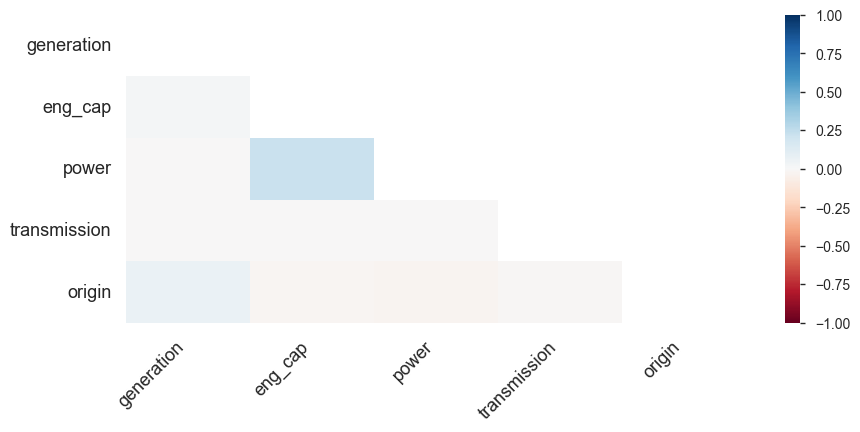

In [181]:
profile = ProfileReport(dataset, title='Car data analysis')
profile

Before further data analysis, let's delete duplicated rows at the beginning:

In [182]:
dataset.drop_duplicates(inplace=True)

As we know from the reality, car model is unique for a certain brand, and also car generation is specific for a certain model, which means that we can drop the brand and model columns, because they are unambiguosly defined by the car generation.

In [183]:
dataset.drop(columns=['brand', 'model'], axis=1, inplace=True)

In [184]:
dataset['generation'].unique()

array(['VII (2012-2020)', 'VIII (2020-)', 'E90/E91/E92/E93 (2005-2012)',
       'D (2006-2014)', 'V (2003-2009)', 'F30/F31 (2012-2020)',
       'VI (2008-2013)', 'G20/G21 (2019-)', 'C (2000-2006)', 'F (2019-)',
       'IV (1997-2006)', 'E (2014-2019)', nan, 'E46 (1998-2007)',
       'I (1974-1983)', 'E30 (1982-1994)', 'III (1991-1998)',
       'B (1993-2000)', 'E36 (1990-1999)', 'E21 (1975-1982)',
       'II (1983-1992)', 'A (1982-1993)'], dtype=object)

*Now, let's take a look at the next columns and their correlation to the price:*

In [185]:
from matplotlib.ticker import MaxNLocator

def correlation_and_distribution_visualisation(df, x_column, bins_nb=None):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0] = sns.countplot(x=x_column, data=df, ax=axs[0])
    if bins_nb:
        axs[0].xaxis.set_major_locator(MaxNLocator(nbins=bins_nb))  # Adjust the number of bins here
    plt.setp(axs[0].xaxis.get_majorticklabels(), rotation='vertical')
    
    axs[1] = sns.barplot(x=x_column, y='price', data=df, ax=axs[1])
    if bins_nb:
        axs[1].xaxis.set_major_locator(MaxNLocator(nbins=bins_nb))  # Adjust the number of bins here
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation='vertical')
    
    plt.tight_layout()
    plt.show()

min_mileage = dataset['mileage'].min()
max_mileage = dataset['mileage'].max()

# Create bins that only include values from the column range
def create_bins(df, col, nb):
    min_ = df[col].min()
    max_ = df[col].max()
    return pd.cut(df[col], bins=np.linspace(min_, max_, nb))

# correlation_and_distribution_visualisation(dataset, 
#                                            create_bins(dataset, 'mileage', 40),
#                                            10)

In [186]:
# temp_dataset = dataset.sort_values('price', ascending=False)
# temp_dataset.head()

Also, let's prepare function for filtering outliers:

In [187]:
def outlier_df(df, col, threshold=3):
    df = df[df[col].notna()]
    z = np.abs(stats.zscore(df[col]))
    print('DEBUG:\n', z[0:3])
    outlier_indices = np.where(z > threshold)[0]
    return df.iloc[outlier_indices]
    #return outlier_indices

# outliners = outlier_df(dataset, 'mileage')
# no_outliers = dataset.drop(outliners.index)
# correlation_and_distribution_visualisation(no_outliers, 
#                                            pd.cut(no_outliers['mileage'], bins=40),
#                                            10)

**eng_cap**

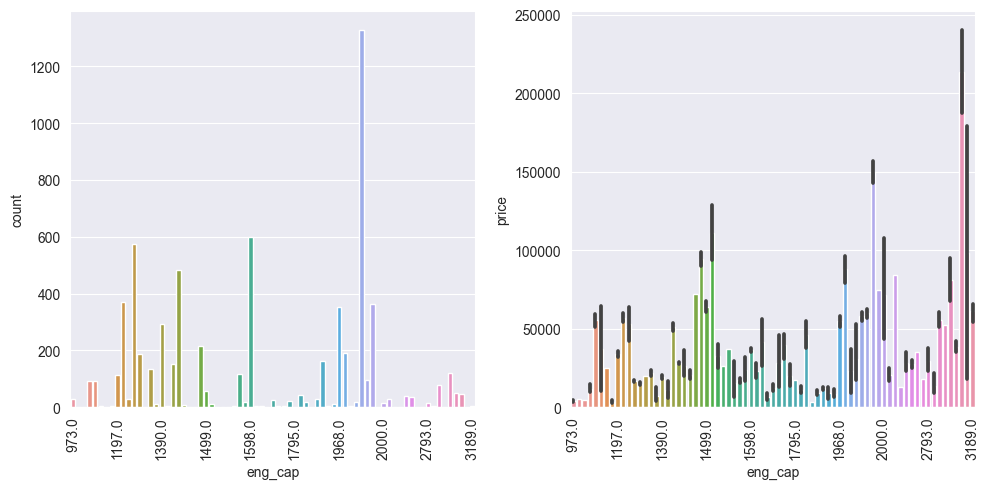

In [188]:
correlation_and_distribution_visualisation(dataset, 'eng_cap', 10)

# ax = sns.countplot(x='eng_cap', data=dataset)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust the number of bins here
# plt.xticks(rotation='vertical')

# #bins = pd.cut(dataset['eng_cap'], bins=20)
# ax = sns.barplot(x='eng_cap', y='price', data=dataset)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust the number of bins here
# plt.xticks(rotation='vertical')
# plt.title('Engine capacity to price correlation')

As we can see, we don't deal with strong correlation between these two values. This is why we will not consider engine capacity as important - it is probably going to be dropped. Probably because we will first check how it influence the predictions of the model - it is highly possible that there are just certain, very popular types of engines (e.g. 2.0) and leaving it can improve the metrics (we will find out later)

In [189]:
outliers_eng_cap = outlier_df(dataset, 'eng_cap')
outliers_eng_cap

DEBUG:
 1550    0.647948
1221    0.611765
1941    0.611765
Name: eng_cap, dtype: float64


generation  eng_cap  prod_year  power fuel_type car_body  mileage  \
1061  V (2003-2009)   3189.0       2008  250.0   Benzyna  Kompakt   233700   
2130  V (2003-2009)   3189.0       2006  250.0   Benzyna  Kompakt   197700   
1347  V (2003-2009)   3189.0       2006  250.0   Benzyna  Kompakt   161000   

          color condition  transmission             origin    price  
1061      Szary   Używane  Automatyczna  Stany Zjednoczone  64500.0  
2130    Srebrny   Używane  Automatyczna              Dania  53900.0  
1347  Granatowy   Używane      Manualna            Szwecja  65800.0

Let's delete outlier rows

In [190]:
dataset.drop(outliers_eng_cap.index, inplace=True)

**prod_year**

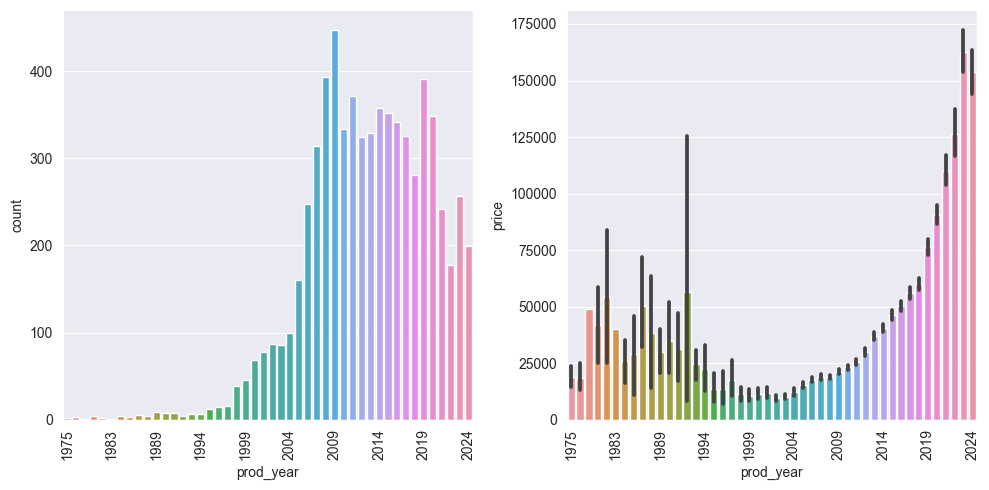

In [191]:
# bins = pd.cut(dataset['prod_year'], bins=20)
# sns.barplot(x=bins, y='price', data=dataset)
# plt.xticks(rotation='vertical')
# plt.title('Production year to price correlation')

correlation_and_distribution_visualisation(dataset, 'prod_year', 10)

We can clearly see strong correlation here. The plot has a shape simillar to parabola. The cars from the left side of the plot are considered *classic cars* and their price is  statisticly higher than a little newer ones. But the newer the car gets, the price starts to raise and is the highest for the latest models. 

We have small amount of samples for old cars, let's see if they can be classified as outliers.

In [192]:
outliers_prod_year = outlier_df(dataset, 'prod_year')
print('Outliers of prod_year:', len(outliers_prod_year))
outliers_prod_year.head()

DEBUG:
 1550    0.617144
1221    1.359531
1941    1.062576
Name: prod_year, dtype: float64
Outliers of prod_year: 58


generation  eng_cap  prod_year  power    fuel_type   car_body  \
561     I (1974-1983)   1085.0       1981   50.0      Benzyna    Kompakt   
237   E30 (1982-1994)   1585.0       1989   99.0      Benzyna      Coupe   
1034  E30 (1982-1994)   2793.0       1989  193.0      Benzyna      Coupe   
2168    I (1974-1983)   1457.0       1977   70.0      Benzyna  Auta małe   
1609  E30 (1982-1994)   1596.0       1990  100.0  Benzyna+LPG      Sedan   

      mileage         color condition transmission origin    price  
561    306000      Czerwony   Używane     Manualna    NaN  24900.0  
237    204000         Szary   Używane     Manualna    NaN  36999.0  
1034   200000  Pomarańczowy   Używane     Manualna    NaN  59900.0  
2168   183855      Czerwony   Używane     Manualna    NaN  17700.0  
1609   384000      Czerwony   Używane     Manualna    NaN  33600.0

Because of high deviation of this samples from the rest, even though they can be good data - it will be better for our future model to remove these from dataset.

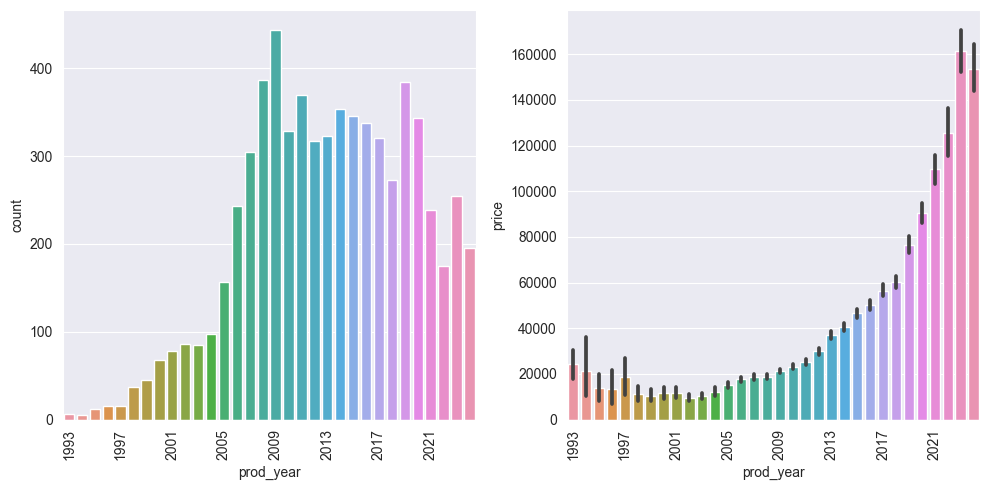

In [193]:
dataset.drop(outliers_prod_year.index, inplace=True)

correlation_and_distribution_visualisation(dataset, 'prod_year', 10)

**power**

C:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


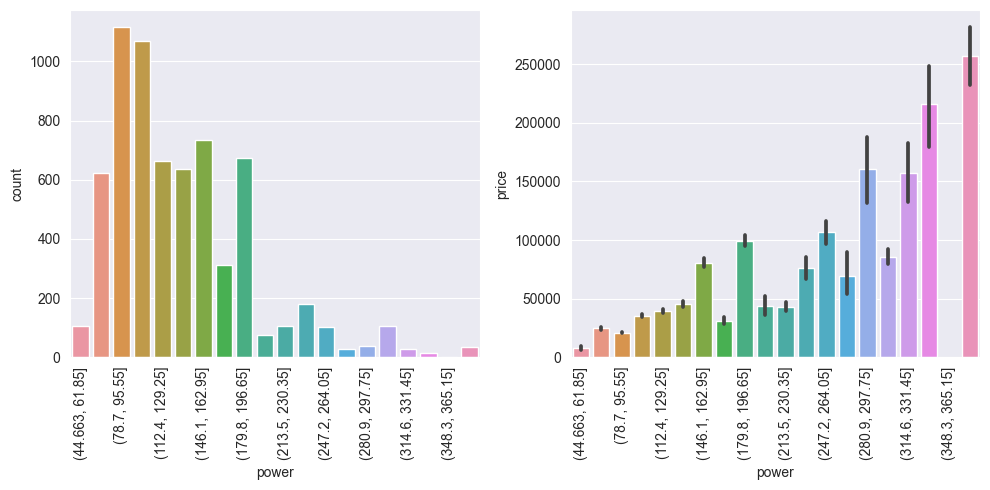

In [194]:
correlation_and_distribution_visualisation(dataset, 
                                           pd.cut(dataset['power'], bins=20), 
                                           10)

The correlation may not be very smooth, but it can be seen that the price goes up along with the power.

Outliers:

In [195]:
outliers_power = outlier_df(dataset, 'power')
outliers_power.head()

DEBUG:
 1550    3.030210
1221    0.249586
1941    0.249586
Name: power, dtype: float64


generation  eng_cap  prod_year  power fuel_type car_body  \
1550      VII (2012-2020)   1984.0       2017  310.0   Benzyna  Kompakt   
966       G20/G21 (2019-)   2998.0       2023  374.0   Benzyna    Sedan   
1800      G20/G21 (2019-)   2998.0       2024  374.0   Benzyna    Sedan   
2260         VIII (2020-)   1984.0       2024  320.0   Benzyna  Kompakt   
2043  F30/F31 (2012-2020)   2993.0       2014  313.0    Diesel    Kombi   

      mileage     color condition  transmission  origin     price  
1550    77000     Biały   Używane  Automatyczna     NaN  114000.0  
966      4100  Czerwony   Używane  Automatyczna  Polska  349900.0  
1800        1    Czarny      Nowe  Automatyczna  Polska  295995.0  
2260       10    Czarny      Nowe  Automatyczna  Polska  267360.0  
2043   230000     Biały   Używane  Automatyczna  Niemcy   59900.0

C:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


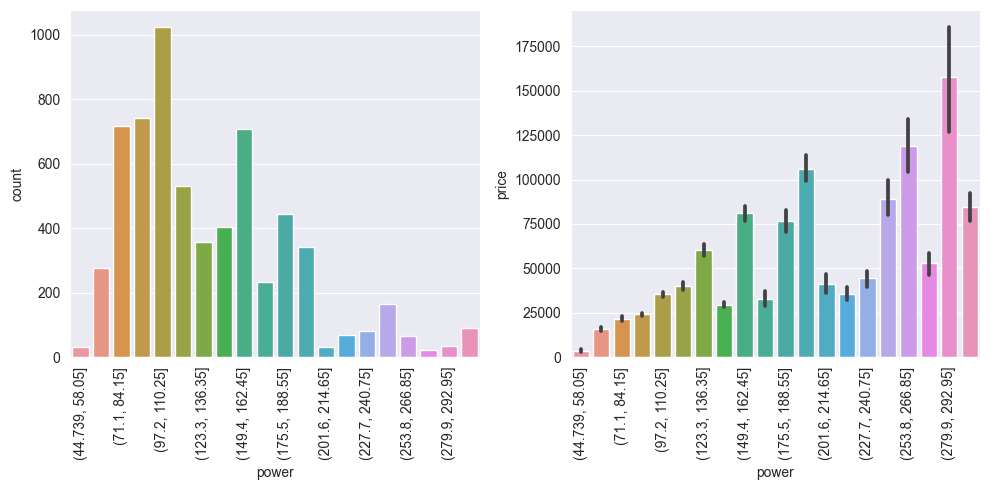

In [196]:
dataset.drop(outliers_power.index, inplace=True)
correlation_and_distribution_visualisation(dataset, 
                                           pd.cut(dataset['power'], bins=20), 
                                           10)

**fuel_type**

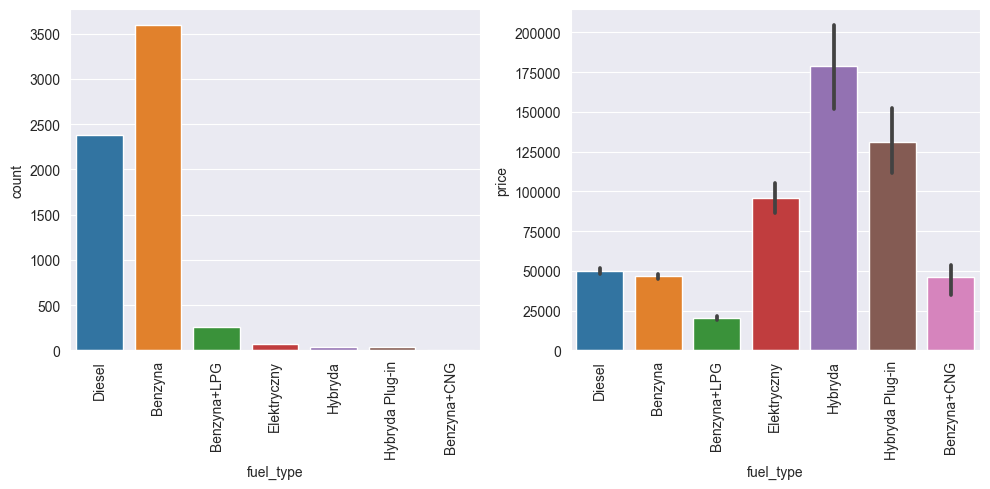

In [197]:
correlation_and_distribution_visualisation(dataset, 'fuel_type')

Only two of all types of fuel can be found in most of the samples, which means it probably won't influence our future model well. It has to be dropped.

In [198]:
dataset.drop(columns='fuel_type', axis=1, inplace=True)

**car_body**

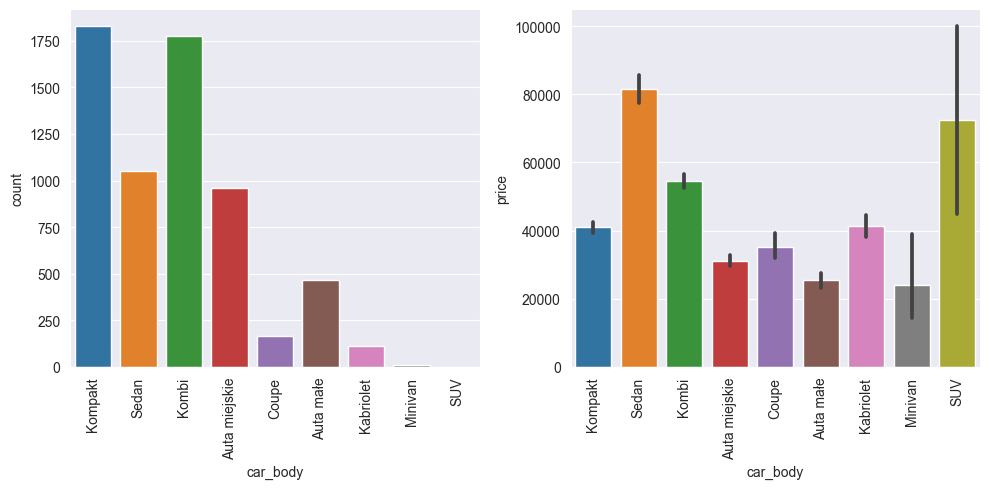

In [199]:
correlation_and_distribution_visualisation(dataset, 'car_body')

The difference in price between different types of car body can be seen. We will leave the column for now but we have to investigate a little.

In [200]:
'''
def show_missing_values():
    nulls = dataset.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values()
'''
def count_unique_from_column(df, col):
    col_count_df = df.groupby([col]).count()['price']
    all_cars = dataset[col].count()
    percentage = col_count_df / all_cars*100
    result_df = pd.concat([col_count_df, percentage], axis=1, keys=['count', '% of all']) 
    result_df = result_df.sort_values(by='% of all', ascending=False)  # Sort by percentage
    return result_df

count_unique_from_column(dataset, 'car_body')


count   % of all
car_body                       
Kompakt         1829  28.681198
Kombi           1777  27.865768
Sedan           1050  16.465423
Auta miejskie    961  15.069782
Auta małe        465   7.291830
Coupe            167   2.618786
Kabriolet        115   1.803356
Minivan           11   0.172495
SUV                2   0.031363

There are only 12 Minivans and 2 SUVs, so it makes no sense to keep these categories, as it will only increase the complexity of the model.

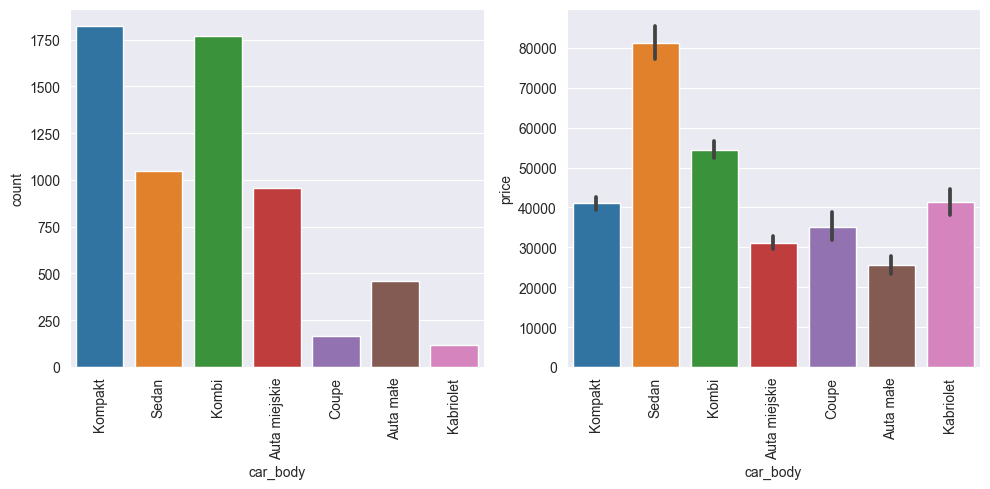

In [201]:
indices_to_drop = dataset[(dataset.get('car_body')=='SUV') | (dataset.get('car_body')=='Minivan')].index
dataset.drop(indices_to_drop, inplace=True)

correlation_and_distribution_visualisation(dataset, 'car_body')

Now it looks slightly better. We still have small amount of samples for Coupe and Convertible, but it should be acceptable. 

**Mileage**

C:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


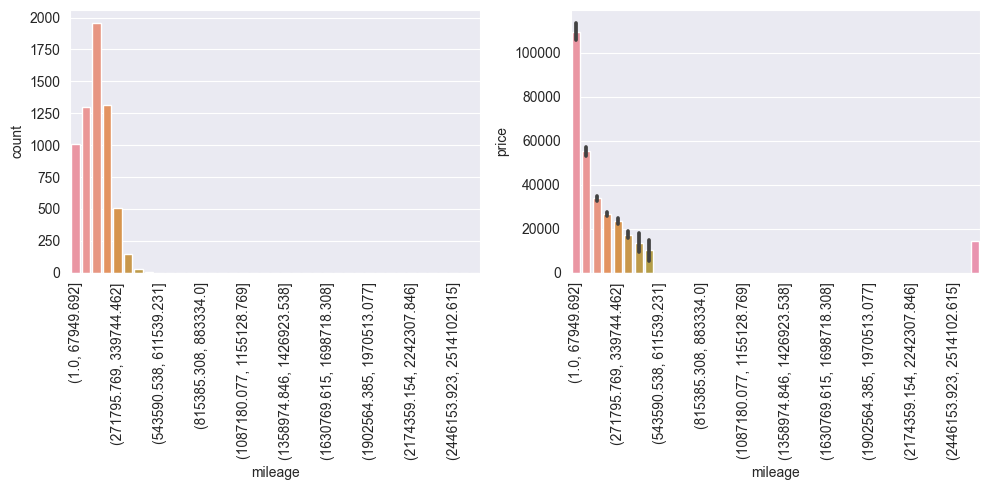

In [202]:
correlation_and_distribution_visualisation(dataset, 
                                           create_bins(df=dataset, col='mileage', nb=40),
                                           10)

As we can see, the data is far from being distributed normally, it looks like there might be some outliers that widen mileage range.

In [203]:
outliers = outlier_df(dataset, 'mileage')
outliers

DEBUG:
 1221    1.360303
1941    0.900620
573     1.321960
Name: mileage, dtype: float64


generation  eng_cap  prod_year  power       car_body  \
2428              E46 (1998-2007)   1951.0       2002  115.0          Kombi   
999                 V (2003-2009)   1896.0       2008  105.0          Kombi   
1591  E90/E91/E92/E93 (2005-2012)   1995.0       2006  163.0          Sedan   
1410              E46 (1998-2007)   1995.0       2004  115.0          Kombi   
171               E36 (1990-1999)   1796.0       1999  115.0      Kabriolet   
2054                D (2006-2014)   1248.0       2010   75.0  Auta miejskie   
1794               VI (2008-2013)   1598.0       2013  105.0          Kombi   
64                 IV (1997-2006)   1896.0       1998   68.0      Auta małe   
1082               IV (1997-2006)   1896.0       2000  115.0        Kompakt   

      mileage       color condition transmission   origin    price  
2428   470000      Czarny   Używane     Manualna   Niemcy   6900.0  
999    520000       Szary   Używane     Manualna   Niemcy   5999.0  
1591   477000  Inny kolor   Używane     Manualna  Francja  16900.0  
1410   450000      Czarny   Używane     Manualna   Niemcy   6900.0  
171   2650000      Czarny   Używane     Manualna      NaN  14500.0  
2054   489500     Srebrny   Używane     Manualna  Francja   9900.0  
1794   485000      Czarny   Używane     Manualna   Niemcy  16200.0  
64     493000     Srebrny   Używane     Manualna      NaN   1999.0  
1082   467400     Srebrny   Używane     Manualna      NaN   3499.0

Indeed there are 9 cars whose mileage is more than 3 times standard deviation. It is highly possible that these are not mistaken data and it is real mileage of this cars but for the model sake, it would be much better if we drop these rows from our dataset

C:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


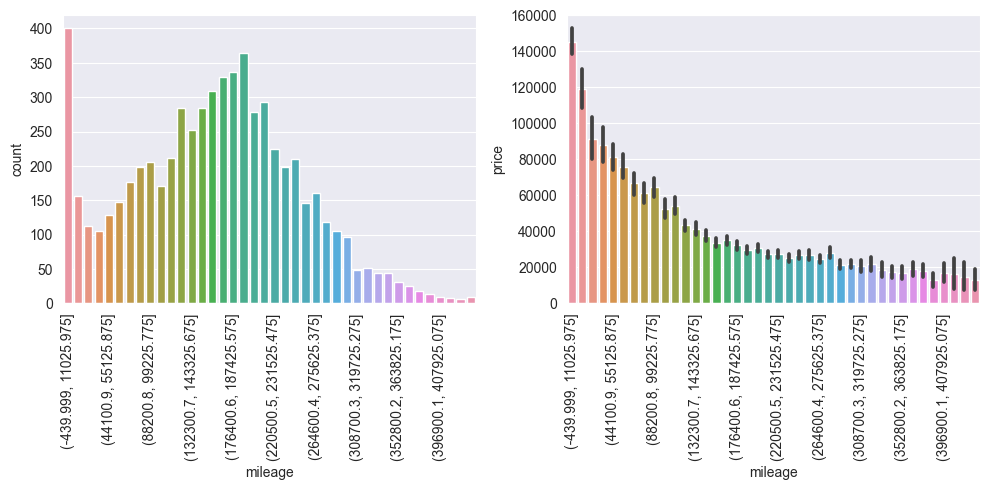

In [204]:
dataset.drop(outliers.index, inplace=True)

correlation_and_distribution_visualisation(dataset, 
                                           pd.cut(dataset['mileage'], bins=40),
                                           10)

As we can see now, our mileage is distributed similarly to the normal distribution. Also, we have very clear correlation between mileage and the price - as it could be predicted - the more a car has been driven, the more its price drops.

**color**

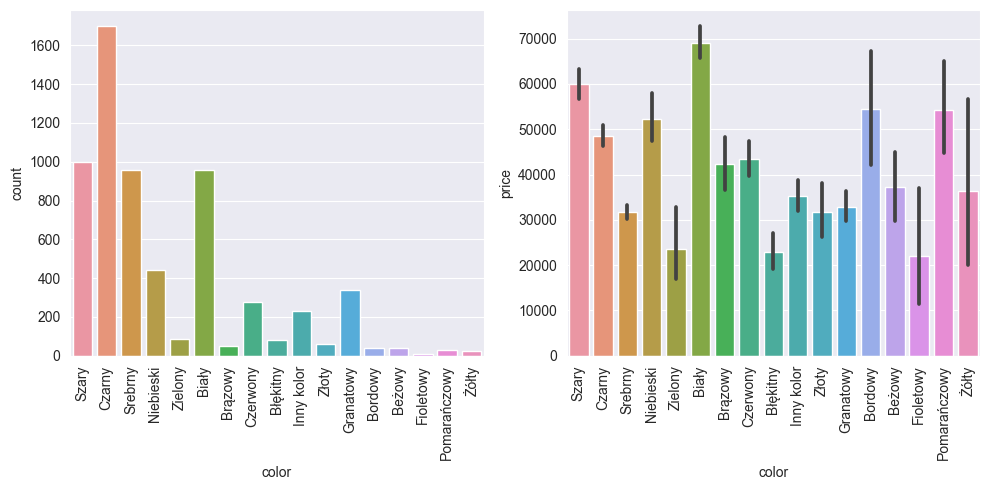

In [205]:
correlation_and_distribution_visualisation(dataset, 'color')

In [206]:
count_unique_from_column(dataset, 'color')

count   % of all
color                         
Czarny         1697  26.868271
Szary           997  15.785307
Biały           958  15.167828
Srebrny         957  15.151995
Niebieski       444   7.029766
Granatowy       337   5.335655
Czerwony        279   4.417353
Inny kolor      230   3.641545
Zielony          86   1.361621
Błękitny         79   1.250792
Złoty            60   0.949968
Brązowy          51   0.807473
Beżowy           38   0.601647
Bordowy          38   0.601647
Pomarańczowy     32   0.506650
Żółty            24   0.379987
Fioletowy         9   0.142495

There are many different colors and only 4 of them makes up the majority, it would be hard to use such data, so we will drop the column

In [207]:
dataset.drop('color', axis=1, inplace=True)

**condition**

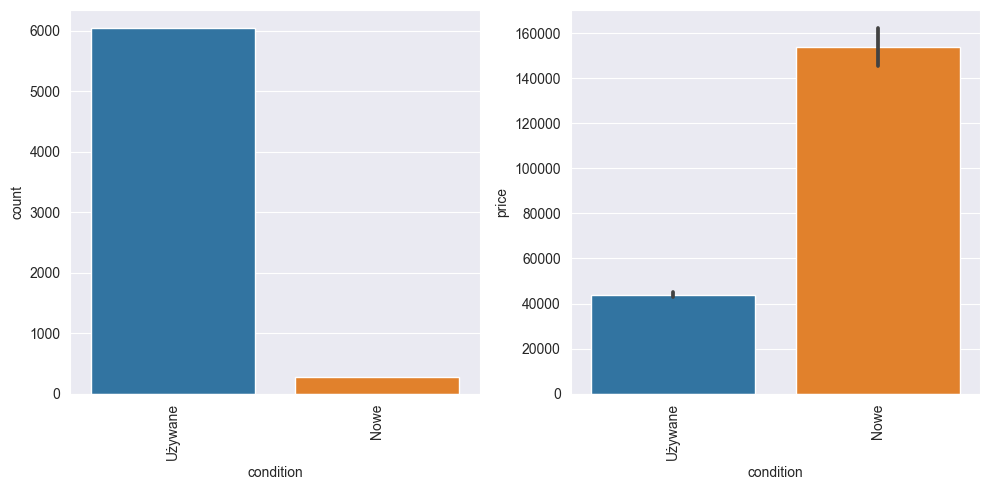

In [208]:
correlation_and_distribution_visualisation(dataset, 'condition')

In [209]:
count_unique_from_column(dataset, 'condition')

count   % of all
condition                  
Używane     6043  95.677644
Nowe         273   4.322356

There is a significant advantage in samples number on the 'used' side, but we cannot simply drop the whole column, because on the other hand new cars are much more expensive than used ones, which can be seen on the plot above. This is why, even though new cars make almost 5% of all the data, we have to drop it. A different approach would be to estimate the price drop just after buying a new car, and decreasing every value of a new car by this percentage. But in our considerations we will limit ourselves to the first option.

In [210]:
indices_to_drop = dataset[(dataset['condition']=='Nowe')].index
dataset.drop(indices_to_drop, inplace=True)

Now, we can also drop the whole column: *condition*

In [211]:
dataset.drop('condition', axis=1, inplace=True)

**transmittion**

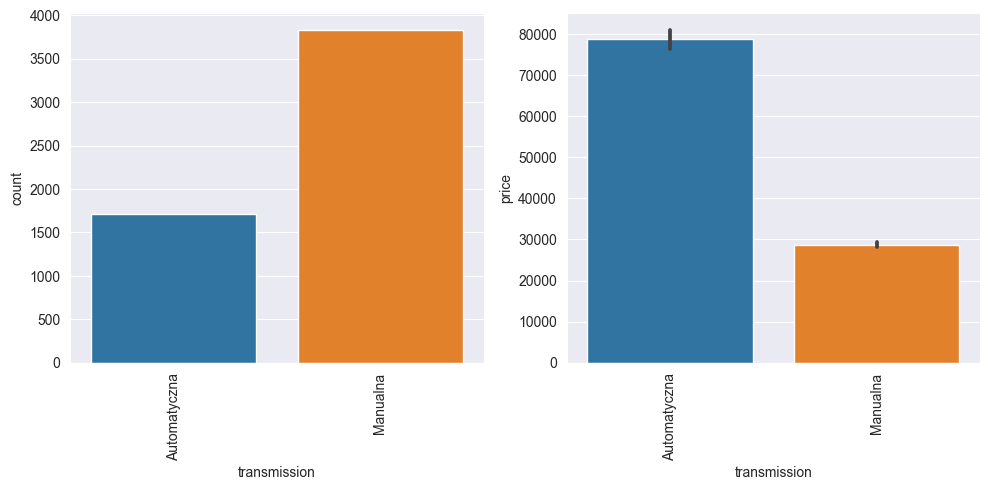

In [212]:
correlation_and_distribution_visualisation(dataset, 'transmission')

In [213]:
count_unique_from_column(dataset, 'transmission')

count  % of all
transmission                 
Manualna       3835  69.13647
Automatyczna   1712  30.86353

Here, we will leave the column as it is. The gap in number of automatic and manual transmittions is not that huge, while the price difference between these two types is noticible.

**origin**

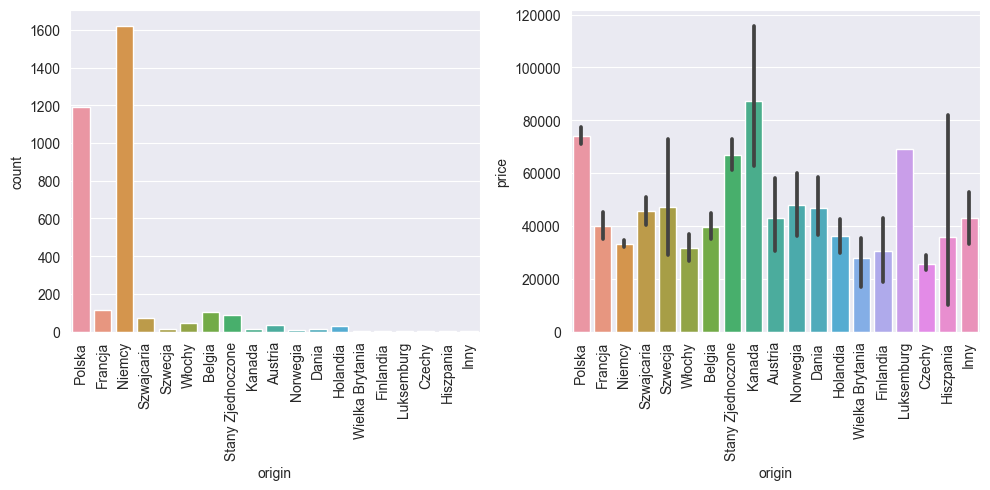

In [214]:
correlation_and_distribution_visualisation(dataset, 'origin')

In [215]:
count_unique_from_column(dataset, 'origin')

count   % of all
origin                             
Niemcy              1623  48.145951
Polska              1189  35.271433
Francja              117   3.470780
Belgia               105   3.114803
Stany Zjednoczone     86   2.551172
Szwajcaria            71   2.106200
Włochy                48   1.423910
Austria               34   1.008603
Holandia              30   0.889944
Dania                 16   0.474637
Szwecja               16   0.474637
Kanada                13   0.385642
Norwegia               6   0.177989
Wielka Brytania        5   0.148324
Hiszpania              3   0.088994
Finlandia              3   0.088994
Czechy                 3   0.088994
Inny                   2   0.059330
Luksemburg             1   0.029665

We don't have enough data about the origin for other countries than Poland and Germany, that is why we are going to drop this column

In [216]:
dataset.drop('origin', axis=1, inplace=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

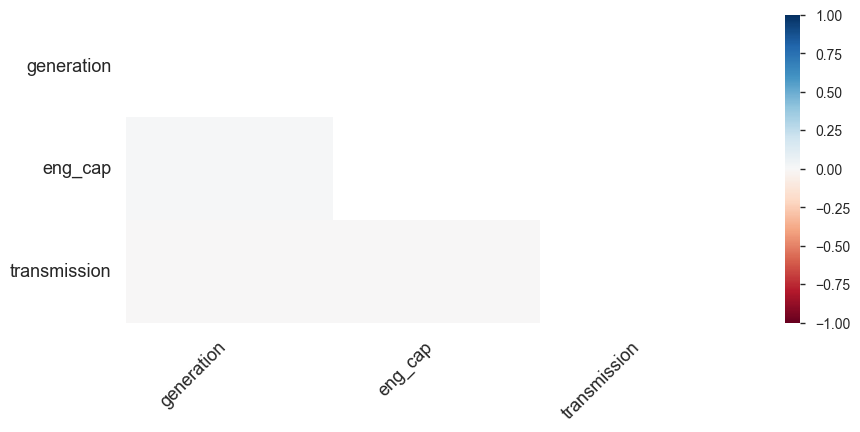

In [217]:
profile = ProfileReport(dataset, title='Car data analysis - after preprocessing')
profile

As the missing cells makes only about 0.2% of the whole dataset, I decided to fill it all at once at the end. I will use following strategy:

for categorical values I will compute probability of occurance for every category and using it i will choose the category for every missing cell

for numeric values i will compute mean end replace empty cells with it 

for *prod_year* and *mileage*, **Gaussian Distribution** could actually be used, but for these columns - there are no empty values so I will just use mean for every column - because the rest is not so simillar to the **Normal Distribution**

In [218]:
categorical = ['generation', 'car_body', 'transmission']
numeric = ['eng_cap', 'prod_year', 'power', 'mileage', 'price']

def fill_na_categorical(df, col):
    na_values = df[col].isna()
    if na_values.any():
        df_dict = count_unique_from_column(df, col).to_dict()['% of all']
        new_values = np.cumsum(list(df_dict.values()))
        for i, key in enumerate(df_dict.keys()):
            df_dict[key] = new_values[i]
        na_indices = np.where(na_values == True)[0]
        replacing_values = []
        for i in range(len(na_indices)):
            r = np.random.random()*100
            for key, val in df_dict.items():
                if r < val:
                    replacing_values.append(key)
                    break
        df.loc[na_values, col] = replacing_values
    return df

def fill_na_numeric(df, col):
    mean = df[col].mean()
    return df.fillna(mean)

for cat_col in categorical:
    dataset = fill_na_categorical(dataset, cat_col)

for num_col in numeric:
    dataset = fill_na_numeric(dataset, num_col)

print('Checking if there is actually no empty values in the whole dataset:')
print(dataset.columns[dataset.isna().any()].tolist())

Checking if there is actually no empty values in the whole dataset:
[]


We got rid of empty cells. Now, ene though we deleted duplicated rows at the beginning, we should do it once again because after data reduction and filling (column dropping, NaN values filling) new duplicates could be created.

In [219]:
dataset.drop_duplicates(inplace=True)

**Categorical Features**

Now let's head to one of the last parts of data preparation - which is transforming categorical columns, to the numeric ones. To perform this operation we are going to use pandas dummy_column

In [220]:
def create_categorical_feature(df, col):
    numeric_df = pd.get_dummies(df[col], prefix=col)
    new_df = df.drop(col, axis=1)
    new_df = pd.concat([new_df, numeric_df], axis=1)
    return new_df

In [221]:
for col in categorical:
    dataset = create_categorical_feature(dataset, col)
dataset.head()

eng_cap  prod_year  power  mileage    price  generation_B (1993-2000)  \
1221   1968.0       2022  150.0    32000  95000.0                     False   
1941   1968.0       2020  150.0    76020  86900.0                     False   
573    2996.0       2005  258.0   288858  32500.0                     False   
1511   1390.0       2007  122.0   180000  13400.0                     False   
1702   1229.0       2008   80.0   187000  14000.0                     False   

      generation_C (2000-2006)  generation_D (2006-2014)  \
1221                     False                     False   
1941                     False                     False   
573                      False                     False   
1511                     False                     False   
1702                     False                      True   

      generation_E (2014-2019)  generation_E30 (1982-1994)  ...  \
1221                     False                       False  ...   
1941                     False                       False  ...   
573                      False                       False  ...   
1511                     False                       False  ...   
1702                     False                       False  ...   

      generation_VIII (2020-)  car_body_Auta małe  car_body_Auta miejskie  \
1221                     True               False                   False   
1941                     True               False                   False   
573                     False               False                   False   
1511                    False               False                   False   
1702                    False               False                    True   

      car_body_Coupe  car_body_Kabriolet  car_body_Kombi  car_body_Kompakt  \
1221           False               False           False              True   
1941           False               False           False              True   
573            False               False           False             False   
1511           False               False            True             False   
1702           False               False           False             False   

      car_body_Sedan  transmission_Automatyczna  transmission_Manualna  
1221           False                       True                  False  
1941           False                       True                  False  
573             True                      False                   True  
1511           False                      False                   True  
1702           False                      False                   True  

[5 rows x 32 columns]

Now, we have to divide our data into X and y, where y is the price and then split our dataset in two parts: training dataset and testing dataset

In [231]:
X_columns = list(dataset.columns)
X_columns.remove('price')
X, y = dataset[X_columns], dataset['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

**Feature Scaling**

the last step in data preparation for our model will be scaling every numeric category (normalization)

In [232]:
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [233]:
scaler = StandardScaler()
def scale_features(df): 
    return scaler.fit_transform(df.astype(float))

X_train = scale_features(X_train)
X_test = scale_features(X_test)

Now, the data should be prepared quite well as the model input. Now we are heading to the part where we experiment to choose the model that predicts our data the best.

## MODELS

**Grid Search**

In [298]:
def find_best_parameters(model, parameters, X, y, cv=5, verbose=1, n_jobs=-1):
    grid_object = GridSearchCV(model, parameters, cv=cv, verbose=verbose, n_jobs=n_jobs)
    grid_object = grid_object.fit(X, y)
    return grid_object.best_estimator_

**Random Forest**

In [291]:
random_forest = RandomForestRegressor()

parameters = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]
             }

random_forest = find_best_parameters(random_forest, parameters, X_train, y_train)
# random_forest.fit(X_train, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


**SVR**

In [312]:
svr = SVR()

parameters = {'C': [1.0, 2.0, 4.0], 
              'gamma': [0.001, 0.1, 1., 10.]
             }

svr = find_best_parameters(svr, parameters, X_train, y_train)

#svr.fit(X_train, y_train)

SVR()

**Gaussian Progress Regressor**

In [301]:
gpr = GaussianProcessRegressor()
gpr.fit(X_train, y_train)

GaussianProcessRegressor()

**Decision Tree**

In [311]:
dtree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

**Gradient Boosting Regressor**

In [318]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

## Best model picking and metrics

In [293]:
from sklearn.metrics import root_mean_squared_error

rf_pred = random_forest.predict(X_test)
svr_pred = svr.predict(X_test)
print(rf_pred[0])
print(y_test[0])

# print('RANDOM FOREST:', mean_squared_error(y_train, rf_pred))
# print('SVR:', mean_squared_error(y_train, svr_pred))
# 
# print(len(X_train))
# print(len(y_train))
# 
# print(len(X_train))
# print(len(y_train))

61878.16107316143
82900.0


In [297]:
for i in range(5):
    print(f'Real: {y_test[i]}\tPredicted: {rf_pred[i]}')
y_test_mean = y_train.mean()
#root_mean_squared_error(y_train[0:10], rf_pred[0:10])
error = root_mean_squared_error(y_test, rf_pred)
print(f'Prediction accuracy: {round((y_test_mean-error)/y_test_mean*100, 2)}%')

Real: 82900.0	Predicted: 61878.16107316143
Real: 4900.0	Predicted: 79732.52651729254
Real: 17900.0	Predicted: 21546.066718664963
Real: 32500.0	Predicted: 31803.929582026358
Real: 18000.0	Predicted: 16471.45876804915
Prediction accuracy: 7.99%


In [319]:
%%capture
random_forest_scores = cross_val_score(random_forest, X_test, y_test, cv=5)
svm_scores = cross_val_score(svr, X_test, y_test, cv=5)
gpr_scores = cross_val_score(gpr, X_test, y_test, cv=5)
dt_scores = cross_val_score(dtree, X_test, y_test, cv=5)
gbr_scores = cross_val_score(gbr, X_test, y_test, cv=5)

In [320]:
results = [
    ['Random Forest', np.mean(random_forest_scores)],
    ['SVM', np.mean(svm_scores)],
    ['Gaussian Process Regressor', np.mean(gpr_scores)],
    ['Decision Tree', np.mean(dt_scores)],
    ['Gradient Boosting Regressor', np.mean(gbr_scores)]
]

results.sort(key = lambda model: model[1])
results = pd.DataFrame(data=results, columns=['Model', 'Score'])
results

Model        Score
0   Gaussian Process Regressor -2790.845218
1                          SVM    -0.098885
2                Decision Tree     0.593506
3                Random Forest     0.889290
4  Gradient Boosting Regressor     0.891212

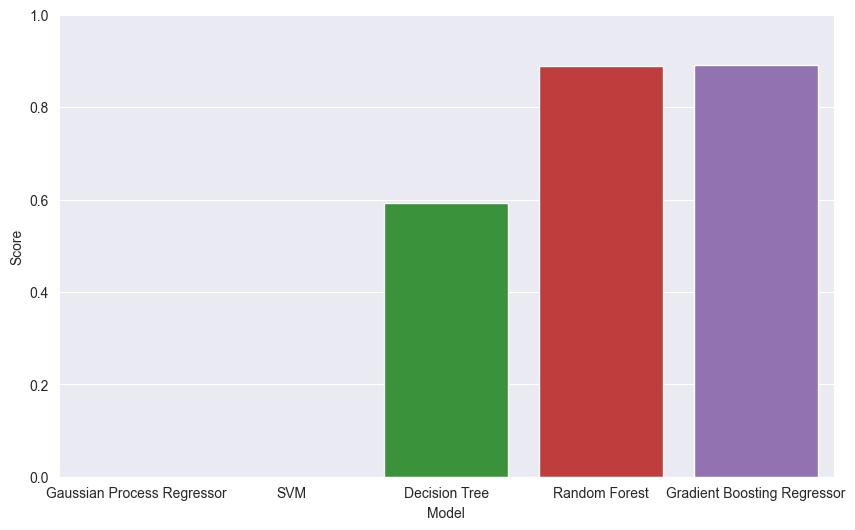

In [321]:
plt.figure(figsize=(10,6))
plot=sns.barplot(x='Model', y='Score', data=results)
plot.set(ylim=(0, 1))
plt.show()